# Common Raster Tasks


### Convert NetCDF data to geotiff

How to extract data from netcdf files (local or remote) and convert it into a geotiff.


### Intersect rasters with vector data

Example of how to take a file containing vector format data (e.g. projected polygons), overlay them onto an array (raster) extracted from either a tiff or netcdf, and extract statistics from the intersecting area.


### Minify rasters

In order to work with rasters, we will often have to minify/lightweight the files. This notebook shows an example of how to do this, using the Rasterio sample data. It involves 1) re-scaling the data to fit an int8 (0-255) representation, and compressing the data (using zip or lzw compression).

In [104]:
from __future__ import print_function

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
from hurry.filesize import size, alternative, verbose
from colorama import Fore, Back, Style
from tqdm import tqdm
%matplotlib inline

In [2]:
with rasterio.open('./data/RGB.byte.tif') as src:
    profile = src.profile
    transform = src.transform
    r, g, b = src.read()

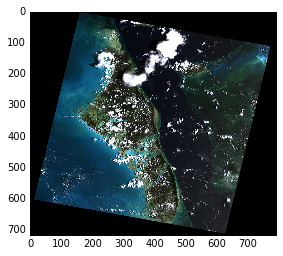

In [3]:
# Preview data with Matplotlib 
img = mpimg.imread('./data/RGB.byte.tif')
plt.imshow(img)

In [4]:
r.max()

255

## Work from a NetCDF File

Using smarter axis manipulation, like pandas, we can use [Xray](http://nbviewer.jupyter.org/github/nicolasfauchereau/metocean/blob/master/notebooks/xray.ipynb) (formerlly xarray).

In [7]:
import xarray as xr

In [8]:
# For plotting and display
import cartopy.crs as ccrs  # Cartopy project http://scitools.org.uk/cartopy/
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

In [9]:
# Connect to a dataset
ncfile = xr.open_dataset("./data/modis_example.nc")

In [10]:
# Introspect the top level of a connected dataset
ncfile

<xarray.Dataset>
Dimensions:                   (lat: 180, lon: 360)
Coordinates:
  * lat                       (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ...
  * lon                       (lon) float32 -179.5 -178.5 -177.5 -176.5 ...
Data variables:
    Cloud_Fraction_Mean_Mean  (lat, lon) float64 0.3214 0.3142 0.3215 0.3183 ...
Attributes:
    Conventions: CF-1.0

In [11]:
# Access metadata layer of a specific variable in a connected dataset
ncfile.Cloud_Fraction_Mean_Mean

<xarray.DataArray 'Cloud_Fraction_Mean_Mean' (lat: 180, lon: 360)>
array([[ 0.321384,  0.314188,  0.321528, ...,  0.31816 ,  0.314324,  0.313344],
       [ 0.329752,  0.335152,  0.33868 , ...,  0.326344,  0.331944,  0.330348],
       [ 0.443748,  0.454672,  0.465576, ...,  0.419704,  0.428532,  0.436016],
       ..., 
       [ 0.793   ,  0.79454 ,  0.79514 , ...,  0.795488,  0.796516,  0.795984],
       [ 0.829696,  0.82914 ,  0.827804, ...,  0.829872,  0.828984,  0.828056],
       [ 0.844236,  0.846888,  0.842844, ...,  0.842616,  0.843956,  0.844476]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Attributes:
    Quality_Assurance_Data_Set: No_QA
    Weighting: Unweighted
    Derived_From_Level_3_Daily_Data_Set: Cloud_Fraction_Mean
    long_name: Cloud Fraction from Cloud Mask (count of lowest 2 clear sky confidence  levels, cloudy & probably cloudy / total co

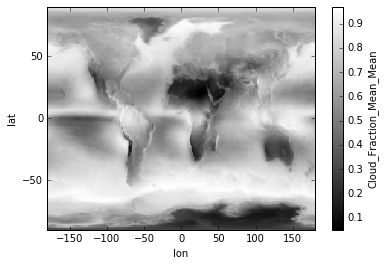

In [456]:
# We can use an equivalent of matplotlib's IMSHOW function to quick view the data array
ncfile.Cloud_Fraction_Mean_Mean[:].plot(cmap=cm.gist_gray)

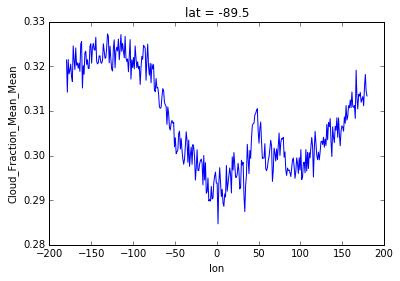

In [13]:
# or plot just a slice across longitude
ncfile.Cloud_Fraction_Mean_Mean[0].plot()

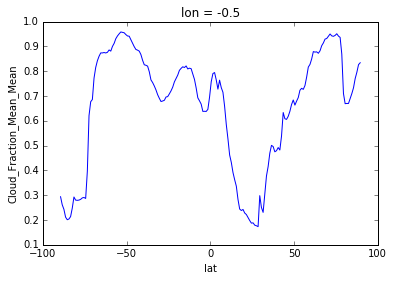

In [14]:
# You can use the attributes to access the array directly
# for example, using every (:) latitude, and the -0.5 longitude as indexes.

ncfile.Cloud_Fraction_Mean_Mean.loc[:,-0.5].plot()

In [15]:
# Elegantly, you can pass a dictionary with the attribute and coordinate specified as an index
pixel = ncfile.Cloud_Fraction_Mean_Mean.loc[{'lat': -0.5, 'lon':-177.5}]
pixel

<xarray.DataArray 'Cloud_Fraction_Mean_Mean' ()>
array(0.5509079694747925)
Coordinates:
    lat      float32 -0.5
    lon      float32 -177.5
Attributes:
    Quality_Assurance_Data_Set: No_QA
    Weighting: Unweighted
    Derived_From_Level_3_Daily_Data_Set: Cloud_Fraction_Mean
    long_name: Cloud Fraction from Cloud Mask (count of lowest 2 clear sky confidence  levels, cloudy & probably cloudy / total count): Mean of Daily Mean
    Statistic_Type: Simple
    units: 1
    Aggregation_Data_Set: None
    valid_range: [    0 10000]
    Included_Level_2_Nighttime_Data: True
    Level_2_Pixel_Values_Read_As: Real
    structureType: Grid
    unitsCategory: fraction

(-90, 90)

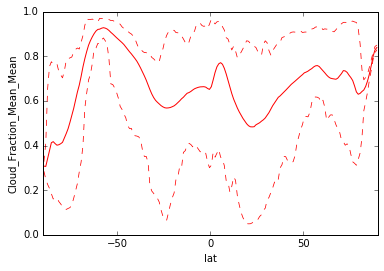

In [16]:
# Grouping by attributes is also easy, for example if we need to group the data by latitude:

lat_mean =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').mean()
lat_max =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').max()
lat_min =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').min()

lat_mean.plot(color='r')
lat_max.plot(color='r',ls='--', lw=0.75)
lat_min.plot(color='r',ls='--', lw=0.75)
plt.xlim(-90,90)

# In this way, it would be possible to mainipulate time dimensions to create seasonal data

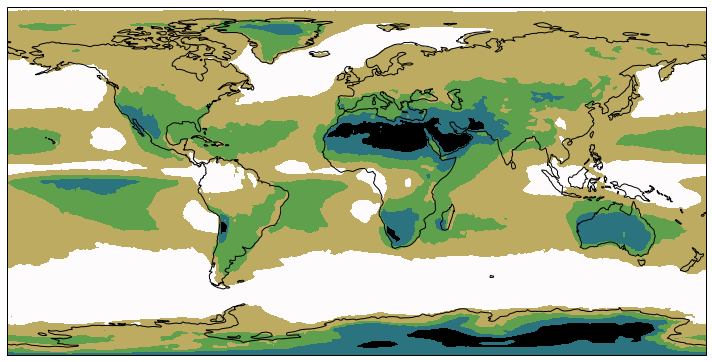

In [465]:
# We can also easily create a more advanced preview plot with boundaries projected using cartopy
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree());
ncfile.Cloud_Fraction_Mean_Mean.plot.contourf(ax=ax, x='lon', y='lat', add_colorbar=False, cmap=cm.gist_earth)
ax.coastlines()
plt.tight_layout()

### Connect to a remote NetCDF file (accessible via OpenDAP)

The [OpenDAP framnework](http://www.opendap.org) enables us to connect to remote datasets painlessly.
We should have this out-of-the box with NetCDF libraries.

Many data centers list their OpenDAP exposed data, e.g. more info at:
* https://disc.sci.gsfc.nasa.gov/disc/services/opendap/
* https://www.esrl.noaa.gov/psd/data/gridded/using_dods.html
* https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/
* https://www.unidata.ucar.edu/software/netcdf/docs/dap_accessing_data.html

In [18]:
url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst2Agg'
ncexample = xr.open_dataset(url)

In [19]:
ncexample

<xarray.Dataset>
Dimensions:    (altitude: 1, latitude: 720, longitude: 1440, time: 12990)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-09-02 1981-09-03 ...
  * altitude   (altitude) float32 0.0
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
Data variables:
    sst        (time, altitude, latitude, longitude) float64 ...
    anom       (time, altitude, latitude, longitude) float64 ...
    err        (time, altitude, latitude, longitude) float64 ...
    ice        (time, altitude, latitude, longitude) float64 ...
Attributes:
    cdm_data_type: Grid
    Contact: Dick Reynolds, email: Richard.W.Reynolds@noaa.gov & Chunying Liu, email: Chunying.liu@noaa.gov
    contributor_name: NOAA NCDC
    contributor_role: Source of data.
    Conventions: COARDS, CF-1.6, ACDD-1.3
    creation_date: 2017-01-19 11:10
    Easternmost_Easting: 359.875
    geospatial_lat_max: 

In [21]:
sst = ncexample.sst[0,0,:,:]  # call the data locally

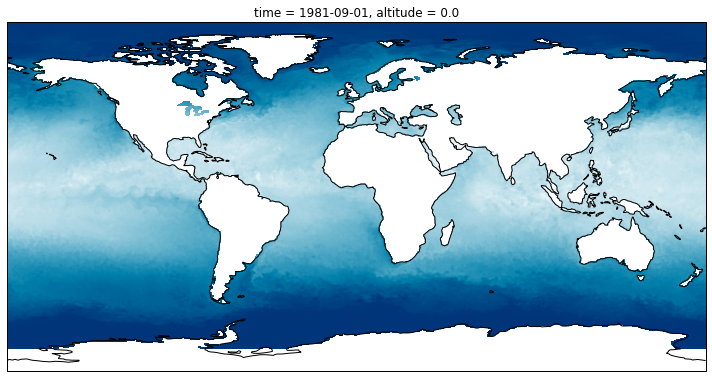

In [432]:
# Graph the data

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree());
sst.plot.pcolormesh(ax=ax, x='longitude', y='latitude',
                                                add_colorbar=False, cmap=cm.ocean)
ax.coastlines()
plt.tight_layout()

### Minify the data

* Describe here how to convert float values to int8 (depending on project goals).

Looking at the 0.5 degree resolution SST data grabbed from the last section, the actual data values are stored in  float64 format. A single array slice itself is ~7MB.

In [102]:
print("Array slice is {0}".format(size(sst.values.nbytes)))

Array slice is 7M


To reduce the size of these data, we can map the values to 8-bit integers, by binning the current data values to a range of 0-255. We need to document the conversion, to reconstruct the physical values upon display.
0 should also be used to represent missing data (so unsigned integers can be used).

Note, this methodology is lossy, so should not be used for purposes where exact data representation is subsequently needed in the vizulisation.

In [110]:
print(f"Valid data range {sst.valid_min} to {sst.valid_max}")

Valid data range -3.0 to 45.0


In [408]:
def convert_array(arr, oldMax, oldMin, missing_value=None):
    """
    Convert an input value into a new value between 1 to 255.
    Missing data are set to 0 values. After this, the array can be saved
    as int8 format to save space. This function should be vectorised before it
    is applied:
    oldMax and oldMin can be directly set to a physical range which you want to
    be static. For example, if you want a range of -30 to +30 degrees, rather
    than to use values from the array itself.
    e.g. f = np.vectorize()
    Note, to avoid having to import numpy if not needed, it relies on the fact
    that NAN values are not equal to themsevels to make the comparison.
    """
    if missing_value:
        mask = arr == missing_value
        arr[mask] = np.nan  # temporarily mask out values that should be missing
    newMin = 1
    newMax = 255
    oldRange = oldMax - oldMin
    newRange = newMax - newMin
    new_arr = (((arr - oldMin) * newRange) / oldRange) + newMin
    missing_mask = np.isnan(new_arr)
    new_arr[missing_mask] = 0
    return np.int32(np.floor(new_arr))

In [448]:
lighter_array = convert_array(sst.values, oldMax=sst.valid_max, oldMin=sst.valid_min)

In [449]:
# The values have now been rescaled between 1 and 255, with 0 as missing data
lighter_array

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [ 11.,  11.,  11., ...,  11.,  11.,  11.],
       [ 11.,  11.,  11., ...,  11.,  11.,  11.],
       [ 11.,  11.,  11., ...,  11.,  11.,  11.]])

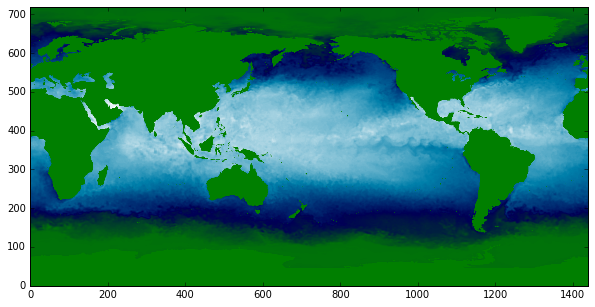

In [458]:
# The resolution is the same
plt.figure(figsize=(10,7))
plt.imshow(lighter_array, cmap=cm.ocean, origin=1)

### Convert Netcdf to GeoTIFF

Decribe here how to extract the array and relevant metadata from a netcdf, and save to GeoTIFF format with compression for efficent upload to web-mapping services.